In [1]:
import pandas as pd
import numpy as np
from pyjet import cluster,DTYPE_PTEPM
from sklearn import preprocessing

# Pre processing

In [2]:
path = '/anomalyvol/data/events_LHCO2020_backgroundMC_Pythia.h5'

In [3]:
df = pd.read_hdf(path,stop=5000) # just read first 100000 events
df

,0,1,2,3,4,5,6,7,8,9,...,2090,2091,2092,2093,2094,2095,2096,2097,2098,2099
0,3.587869,-2.323472,-2.597121,1.497173,-2.480994,-2.269457,0.848844,-2.465643,-2.096595,0.961511,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.921213,-0.745233,1.018857,0.689363,-0.642245,3.050711,1.999174,-0.343135,-0.322586,1.580572,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.580352,-2.412026,1.680236,0.429869,-0.778697,-1.453413,0.856914,-2.243512,0.217628,0.407344,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.579134,-0.243543,-2.561824,0.312690,-0.283086,-0.281626,0.775053,-2.062494,-1.598718,0.868891,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.644219,-2.457281,-2.670996,0.186128,-1.757650,2.719159,0.346987,-2.318233,-0.155036,0.501437,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.578935,-1.251851,-2.358805,0.354713,-0.180199,0.731343,1.048696,-1.031479,-0.956550,0.968440,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4996,0.222244,-0.376612,1.071711,0.967087,-2.237488,-1.870470,0.377234,-1.306800,2.642717,1.566379,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4997,1.479221,-1.356321,1.618150,2.503858,-1.079203,1.983957,5.551156,-1.024912,1.965017,1.576914,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4998,0.669072,-0.404555,0.827083,0.600054,-0.367350,1.268752,5.808274,-0.563534,-2.600536,7.719838,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
all_events = df.values

In [5]:
rows = all_events.shape[0]
cols = all_events.shape[1]
data = []

In [6]:
for i in range(rows):
    pseudojets_input = np.zeros(len([x for x in all_events[i][::3] if x > 0]), dtype=DTYPE_PTEPM)
    for j in range(cols // 3):
        if (all_events[i][j*3]>0):
            pseudojets_input[j]['pT'] = all_events[i][j*3]
            pseudojets_input[j]['eta'] = all_events[i][j*3+1]
            pseudojets_input[j]['phi'] = all_events[i][j*3+2]
        pass
    sequence = cluster(pseudojets_input, R=1.0, p=-1)
    jets = sequence.inclusive_jets()
    for k in range(len(jets)):
        jet_parts = [list(l) for l in jets[k].constituents_array()]
        
        # pad jets
        if (len(jet_parts) < 100):
            pads = 100 - len(jet_parts)
            for p in range(pads):
                jet_parts.append([0,0,0,0])
        else:
            jet_parts = jet_parts[0:100]  # just get 100 particles for this jet (arbitrary)
    
        data.append(jet_parts)

In [7]:
# transform data into format easier for scaling with sklearn ([n_particles, 4])
d = []
for i in range(len(data)):
    for j in range(100):
        d.append(data[i][j])
data = d

In [8]:
data = np.array(data)
data.shape

(7364100, 4)

In [9]:
# splitting data (rounding by 100)
x_train = data[0:int(round(len(data) * 0.8, -2))]
x_val = data[int(round(len(data) * 0.8, -2)):int(round(len(data) * 0.9, -2))]
x_test = data[int(round(len(data) * 0.9, -2)):]

In [10]:
# regularize
scaler = preprocessing.StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

In [11]:
x_train = np.reshape(x_train, (-1,100,4))
x_val = np.reshape(x_val, (-1,100,4))
x_test = np.reshape(x_test, (-1,100,4))

In [12]:
x_test.shape

(7364, 100, 4)

# VAE Model

In [13]:
import keras
from keras.layers import Lambda, Input, Dense, Flatten, Reshape
from keras.models import Model, Sequential
from keras import metrics, losses
from keras import backend as K

Using TensorFlow backend.


In [14]:
def sampling(args):
    """
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [15]:
inter_dim_1 = 256
inter_dim_2 = 128
final_dim = 64
latent_dim = 32
input_dim = (100,4)

In [16]:
# encoder
x = Input(shape=input_dim)
x_flat = Flatten()(x)
h1 = Dense(inter_dim_1, activation='relu')(x_flat)
h2 = Dense(inter_dim_2, activation='relu')(h1)
h3 = Dense(final_dim, activation='relu')(h2)
z_mean = Dense(latent_dim)(h3)
z_log_sigma = Dense(latent_dim)(h2)

In [17]:
x.shape

TensorShape([None, 100, 4])

In [18]:
# random sampling
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

encoder = Model(inputs = x, outputs = z)

In [19]:
# decoder
decoder_h3 = Dense(final_dim, activation='relu')
decoder_h2 = Dense(inter_dim_2, activation='relu')
decoder_h1 = Dense(inter_dim_1, activation='relu')
decoder_mean = Dense(np.prod(input_dim), activation='linear')

h3_decoded = decoder_h3(z)
h2_decoded = decoder_h2(h3_decoded)
h1_decoded = decoder_h1(h2_decoded)
x_decoded_mean = decoder_mean(h1_decoded)
x_decoded = Reshape(input_dim)(x_decoded_mean)

In [20]:
vae = Model(inputs = x, outputs = x_decoded_mean, name = 'vae')

In [21]:
mse = keras.losses.MeanSquaredError()
def vae_loss(x, y):
    mse_loss = mse(K.flatten(x), K.flatten(y))
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return mse_loss + kl_loss

vae.compile(optimizer='adam', loss=vae_loss)

In [22]:
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 4)       0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 400)          0           input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 400)          160400      flatten_1[0][0]                  
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 256)          102656      dense_1[0][0]                    
________________________________________________________________________________________________

# Train

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
batch_size = 1000
epochs = 100

In [25]:
x_train.shape

(58913, 100, 4)

In [26]:
my_callbacks = [
    keras.callbacks.EarlyStopping(patience=10)
]

In [27]:
hist = vae.fit(x_train, x_train,
               shuffle=True,
               epochs=epochs,
               batch_size=batch_size,
               validation_data=(x_val, x_val),
               callbacks=my_callbacks)

Train on 58913 samples, validate on 7364 samples
Epoch 1/100
58913/58913 [==============================] - 2s 28us/step - loss: 1.0285 - val_loss: 0.9778
Epoch 2/100
58913/58913 [==============================] - 1s 14us/step - loss: 1.0000 - val_loss: 0.9767
Epoch 3/100
58913/58913 [==============================] - 1s 14us/step - loss: 0.9994 - val_loss: 0.9765
Epoch 4/100
58913/58913 [==============================] - 1s 15us/step - loss: 0.9993 - val_loss: 0.9764
Epoch 5/100
58913/58913 [==============================] - 1s 14us/step - loss: 0.9993 - val_loss: 0.9764
Epoch 6/100
58913/58913 [==============================] - 1s 14us/step - loss: 0.9992 - val_loss: 0.9764
Epoch 7/100
58913/58913 [==============================] - 1s 14us/step - loss: 0.9992 - val_loss: 0.9764
Epoch 8/100
58913/58913 [==============================] - 1s 14us/step - loss: 0.9992 - val_loss: 0.9764
Epoch 9/100
58913/58913 [==============================] - 1s 14us/step - loss: 0.9992 - val_loss: 0.97

# Visualization

In [28]:
import matplotlib.pyplot as plt

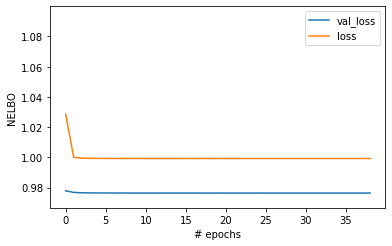

In [29]:
golden_size = lambda width: (width, 2. * width / (1 + np.sqrt(5)))

fig, ax = plt.subplots(figsize=golden_size(6))

hist_df = pd.DataFrame(hist.history)
hist_df.plot(ax=ax)

ax.set_ylabel('NELBO')
ax.set_xlabel('# epochs')

ax.set_ylim(.99*hist_df[1:].values.min(), 
            1.1*hist_df[1:].values.max())
plt.show()

In [30]:
predictions = vae.predict(x_test)

In [31]:
predictions.shape

(7364, 400)

In [32]:
distr = (x_test - predictions) / x_test

ValueError: operands could not be broadcast together with shapes (7364,100,4) (7364,400) 

In [ ]:
pT_pred = [row[0] for row in predictions]
eta_pred = [row[1] for row in predictions]
phi_pred = [row[2] for row in predictions]
mass_pred = [row[3] for row in predictions]

In [ ]:
pT = [row[0] for row in x_test]
eta = [row[1] for row in x_test]
phi = [row[2] for row in x_test]
mass = [row[3] for row in x_test]

## Stacking output (orange) over input (blue) for pT, eta, phi, m

In [ ]:
bins = np.linspace(-3, 3, 80)
plt.hist(pT, bins=bins,alpha=0.5)
plt.hist(pT_pred, bins=bins,alpha=0.5)
bins = np.linspace(-0.45, -0.2, 40)

In [ ]:
bins = np.linspace(-5, 5, 100)
plt.hist(eta, bins=bins,alpha=0.5)
plt.hist(eta_pred, bins=bins,alpha=0.5)

In [ ]:
bins = np.linspace(-4,4, 100)
plt.hist(phi, bins=bins,alpha=0.5)
plt.hist(phi_pred, bins=bins,alpha=0.5)

In [ ]:
bins = np.linspace(-1,1, 60)
plt.hist(mass, bins=bins,alpha=0.5)
plt.hist(mass_pred, bins=bins,alpha=0.5)

In [ ]:
d_pT = [row[0] for row in distr]
d_eta = [row[1] for row in distr]
d_phi = [row[2] for row in distr]
d_mass = [row[3] for row in distr]

## Distribution of (input - output) / input

In [ ]:
bins = np.linspace(-2, 2, 30)

In [ ]:
plt.hist(d_pT, bins=bins)

In [ ]:
plt.hist(d_eta, bins=bins)

In [ ]:
plt.hist(d_phi, bins=bins)